#### Note that in this version of OptScale 1, we no longer use MuSigmaPredictor for MLE starting point. Instead, we set Mu = 0.8 and Sigma = 0.2 for all datasets, making this a simplified but still effective OptScale.

In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import root
from scipy.optimize import minimize
from tqdm import tqdm
import os 

from utils import *

# Set random seed for reproducibility (same as in train_predictor_initial.py)
torch.manual_seed(42)
np.random.seed(42)


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

DATASET = 'AMC23'

/home/wangyoukang/anaconda3/envs/test_scale/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:1


In [2]:
# Initialize tokenizer - same model as in train_predictor_initial.py
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def load_validation_data(batch_size=16):
    with open('../data/test_prompts/amc23.json', 'r') as f:
        dataset = json.load(f)
        
    with open('../data/completions/r1_distill_qwen7b/parallel/scored_qwen7b_par_amc23_64.json', 'r') as f:
        completion_data = json.load(f)
    
    # Prepare data
    texts = [item['problem'] for item in dataset]
    gt_answers = [item['answer'] for item in dataset]
    completions = [item['score']['completions'] for item in completion_data]
    completion_tokens = [item['score']['completion_tokens'] for item in completion_data]
    scores = [item['score']['scores'] for item in completion_data]
    
    val_texts = texts
    val_gt_answers = gt_answers
    val_completions = completions
    val_completion_tokens = completion_tokens
    val_scores = scores
    
    print(f"Total dataset size: {len(texts)}")
    print(f"Validation size: {len(val_texts)}")
    
    # Load or predict mu/sigma parameters
    if os.path.exists(f'{DATASET}_train_mu_sigma.json'):
        print("Loading existing mu/sigma parameters...")
        with open(f'{DATASET}_train_mu_sigma.json', 'r') as f:
            val_labels = json.load(f)
    else:
        print("Predicting mu/sigma parameters using QwenMuSigmaPredictor...")
        
        # Clear GPU cache before loading model
        torch.cuda.empty_cache()
        
        # Load model on CPU first to avoid GPU memory issues
        # print("Loading model on CPU first...")
        model = QwenMuSigmaPredictor(model_name).to(device)
        
        # Load checkpoint on CPU
        checkpoint_path = '../train_predictor/checkpoints_direct_qwen_real/best_predictor_model_direct_qwen_real.pt'
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint)
        
        # # Move model to GPU after loading checkpoint
        # print("Moving model to GPU...")
        # model = model.to(device)
        # model.eval()
        
        # # Clear CPU cache
        # del checkpoint
        # torch.cuda.empty_cache()
        
        # Create dataset and dataloader for prediction
        val_dataset = TextDatasetNoLabels(val_texts, tokenizer)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Make predictions
        val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids, attention_mask)
                val_labels.extend(outputs.cpu().numpy().tolist())
        
        # Save predictions
        with open(f'{DATASET}_train_mu_sigma.json', 'w') as f:
            json.dump(val_labels, f)
            
    # Create validation dataset and dataloader
    val_dataset = TextDataset(val_texts, val_labels, tokenizer)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return val_loader, val_texts, val_gt_answers, val_completions, val_completion_tokens, val_scores, val_labels, tokenizer

# Load validation data
val_loader, val_texts, val_gt_answers, val_completions, val_completion_tokens, val_scores, val_labels, tokenizer = load_validation_data()


Total dataset size: 40
Validation size: 40
Predicting mu/sigma parameters using QwenMuSigmaPredictor...
Qwen2Model(
  (embed_tokens): Embedding(151936, 1536)
  (layers): ModuleList(
    (0-27): 28 x Qwen2DecoderLayer(
      (self_attn): Qwen2Attention(
        (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
        (k_proj): Linear(in_features=1536, out_features=256, bias=True)
        (v_proj): Linear(in_features=1536, out_features=256, bias=True)
        (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
    )
  )
  (norm): Qwen2RMSNorm((1536

In [3]:
# Ground truth parameters (using full data)
original_params_compare = []
for idx, score in enumerate(val_scores):
    data = np.array(score[0][:100])
    initial_mu = np.mean(data)
    initial_sigma = np.std(data)
    result = minimize(lambda params: neg_log_likelihood(params, data), 
                     [initial_mu, initial_sigma],
                     bounds=[(None, None), (1e-6, None)], 
                     method='L-BFGS-B')
    mu_hat, sigma_hat = result.x
    original_params_compare.append((mu_hat, sigma_hat))

# Estimates using limited data (first 10 samples)
mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

print("\nComparison of Estimation Methods (first 10 examples):")
print("ID   Predictor_μ   Predictor_σ  MLE_μ     MLE_σ     MAP_μ     MAP_σ     GT_μ      GT_σ")
print("-" * 90)

peek_number = 3

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


/home/wangyoukang/anaconda3/envs/test_scale/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0



Comparison of Estimation Methods (first 10 examples):
ID   Predictor_μ   Predictor_σ  MLE_μ     MLE_σ     MAP_μ     MAP_σ     GT_μ      GT_σ
------------------------------------------------------------------------------------------
0         0.5888      0.1438    0.9918    0.0056    0.7848    0.1984   11.1844    0.3358
1         0.4565      0.0747    0.9854    0.0069    0.6557    0.2332    0.9915    0.0055
2         0.4358      0.0651    0.9786    0.0113    0.6357    0.2357    0.9800    0.0112
3         0.4280      0.0684    0.9871    0.0084    0.6236    0.2447    1.0509    0.0347
4         0.5449      0.1461    0.8664    0.1762    0.6758    0.1766   61.4234    2.0890
5         0.4186      0.0189    0.9821    0.0030    0.6366    0.2256   71.0465    1.8965
6         0.6573      0.1089    0.7171    0.0865    0.7044    0.0900    0.7766    0.1199
7         0.6261      0.1181    0.6132    0.0439    0.6141    0.0465    0.9498    0.2272
8         0.2787      0.0185    0.9699    0.1272    0.4

In [4]:
# Load baseline results
with open(f'{DATASET}_BoN_results.json', 'r') as f:
    data = json.load(f)

# Reconstruct the baseline arrays
baseline_accuracy_values = []
baseline_average_token_counts = []

for item in data:
    baseline_accuracy_values.append(item['accuracy'])
    baseline_average_token_counts.append(item['token_count'])

Target Score Panel: [0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 8

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [3, 3, 3, 3, 5, 3, 8, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 8, 3, 3, 3, 5, 4, 3, 3, 3]


MLE - Target Score: 0.75, Percentile: 0.01
MLE - Accuracy: 0.9250, Average Token Count: 23760.58
MLE Min N Required [3, 3, 3, 3, 4, 3, 8, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3]
MLE - Target Score: 0.75, Percentile: 0.02
MLE - Accuracy: 0.9250, Average Token Count: 22870.03
MLE Min N Required [3, 3, 3, 3, 4, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3]
MLE - Target Score: 0.75, Percentile: 0.035
MLE - Accuracy: 0.9250, Average Token Count: 21681.45


MLE Min N Required [3, 3, 3, 3, 3, 3, 7, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3]
MLE - Target Score: 0.75, Percentile: 0.05
MLE - Accuracy: 0.9250, Average Token Count: 21305.17
MLE Min N Required [3, 3, 3, 3, 3, 3, 7, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3]
MLE - Target Score: 0.75, Percentile: 0.075
MLE - Accuracy: 0.9250, Average Token Count: 21008.38


Target Score (MLE):  14%|█▍        | 1/7 [00:00<00:03,  1.97it/s]

MLE Min N Required [3, 3, 3, 3, 3, 3, 6, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3]
MLE - Target Score: 0.75, Percentile: 0.1
MLE - Accuracy: 0.9250, Average Token Count: 19881.25


MLE Min N Required [3, 3, 3, 3, 6, 3, 8, 8, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 3, 3, 8, 3, 3, 3, 8, 4, 4, 3, 3]
MLE - Target Score: 0.8, Percentile: 0.01
MLE - Accuracy: 0.9250, Average Token Count: 26159.75
MLE Min N Required [3, 3, 3, 3, 5, 3, 8, 8, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 8, 3, 3, 3, 8, 4, 4, 3, 3]


MLE - Target Score: 0.8, Percentile: 0.02
MLE - Accuracy: 0.9250, Average Token Count: 25255.53
MLE Min N Required [3, 3, 3, 3, 5, 3, 8, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 8, 3, 3, 3, 7, 3, 3, 3, 3]
MLE - Target Score: 0.8, Percentile: 0.035
MLE - Accuracy: 0.9250, Average Token Count: 23960.00


MLE Min N Required [3, 3, 3, 3, 4, 3, 8, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 3, 3, 3, 6, 3, 3, 3, 3]
MLE - Target Score: 0.8, Percentile: 0.05
MLE - Accuracy: 0.9250, Average Token Count: 23461.88
MLE Min N Required [3, 3, 3, 3, 4, 3, 8, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 3, 3, 3, 5, 3, 3, 3, 3]
MLE - Target Score: 0.8, Percentile: 0.075
MLE - Accuracy: 0.9250, Average Token Count: 23165.95
MLE Min N Required [3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 3, 5, 3, 3, 3, 3]


Target Score (MLE):  29%|██▊       | 2/7 [00:00<00:02,  2.47it/s]

MLE - Target Score: 0.8, Percentile: 0.1
MLE - Accuracy: 0.9250, Average Token Count: 22490.90


MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 4, 3, 3, 3, 4, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 7, 3, 3, 8, 3, 3, 3, 8, 6, 6, 3, 7]


MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 29287.72
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 6, 3, 3, 8, 3, 3, 3, 8, 5, 5, 3, 6]
MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9250, Average Token Count: 28522.95
MLE Min N Required [3, 3, 3, 3, 7, 3, 8, 8, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 6, 3, 3, 8, 3, 3, 3, 8, 5, 5, 3, 5]
MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9250, Average Token Count: 27692.72


MLE Min N Required [3, 3, 3, 3, 6, 3, 8, 8, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 5, 3, 3, 8, 3, 3, 3, 8, 4, 4, 3, 5]
MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9250, Average Token Count: 26919.55
MLE Min N Required [3, 3, 3, 3, 6, 3, 8, 8, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 7, 4, 3, 3, 8, 3, 3, 3, 8, 4, 4, 3, 4]
MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9250, Average Token Count: 25808.67
MLE Min N Required [3, 3, 3, 3, 5, 3, 8, 8, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 6, 4, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 4]


Target Score (MLE):  43%|████▎     | 3/7 [00:01<00:01,  2.57it/s]

MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9250, Average Token Count: 25001.95


MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 7, 3, 3, 4, 6, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 8]
MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 30899.45


MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 6, 3, 3, 3, 5, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 8]
MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 30485.33
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 5, 3, 3, 3, 4, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 7, 7, 3, 8]
MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 29963.47
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 5, 3, 3, 3, 4, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 6, 7, 3, 8]


MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 29839.03
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 5, 6, 3, 8]


Target Score (MLE):  57%|█████▋    | 4/7 [00:01<00:01,  2.55it/s]

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 29350.80
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 5, 5, 3, 8]
MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9250, Average Token Count: 29207.08


MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 7, 8, 8, 3, 3, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 8, 8, 4, 8]
MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 32015.08


MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 6, 7, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 8]
MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 31601.83
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 7, 3, 3, 5, 6, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 8]
MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 31029.95


MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 7, 3, 3, 4, 5, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 8]
MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 30740.92
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 6, 3, 3, 4, 4, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 7, 8, 3, 8]


Target Score (MLE):  71%|███████▏  | 5/7 [00:02<00:00,  2.48it/s]

MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 30316.12
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 5, 3, 3, 4, 4, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 7, 7, 3, 8]
MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 30073.33


MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 3, 6, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 6, 3, 3, 8, 8, 8, 7, 8]
MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 33577.97
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 3, 5, 3, 3, 8, 3, 8, 3, 7, 3, 3, 3, 3, 8, 8, 3, 3, 8, 5, 3, 3, 8, 8, 8, 6, 8]


MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 33087.32
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 3, 4, 3, 3, 8, 3, 8, 3, 6, 3, 3, 3, 3, 8, 8, 3, 3, 8, 5, 3, 3, 8, 8, 8, 5, 8]
MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 32837.95


MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 8, 7, 8, 3, 4, 3, 3, 8, 3, 8, 3, 5, 3, 3, 3, 3, 8, 8, 3, 3, 8, 4, 3, 3, 8, 8, 8, 4, 8]
MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 32437.75
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 8, 6, 8, 3, 3, 3, 3, 8, 3, 8, 3, 5, 3, 3, 3, 3, 8, 8, 3, 3, 8, 4, 3, 3, 8, 8, 8, 4, 8]


Target Score (MLE):  86%|████████▌ | 6/7 [00:02<00:00,  2.42it/s]

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 32188.92
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 7, 6, 8, 3, 3, 3, 3, 8, 3, 8, 3, 4, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 8, 8, 8, 4, 8]
MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 31747.83


MLE Min N Required [3, 3, 6, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 4, 6, 3, 3, 8, 8, 3, 5, 8, 8, 3, 3, 8, 8, 8, 8, 8]
MLE - Target Score: 0.975, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 36123.28


MLE Min N Required [3, 3, 5, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 7, 8, 8, 8, 8, 3, 8, 3, 8, 4, 5, 3, 3, 8, 8, 3, 5, 8, 8, 3, 3, 8, 8, 8, 8, 8]
MLE - Target Score: 0.975, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 35932.50
MLE Min N Required [3, 3, 4, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 3, 8, 3, 4, 3, 3, 8, 8, 3, 4, 8, 8, 3, 3, 8, 8, 8, 8, 8]
MLE - Target Score: 0.975, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 35578.12
MLE Min N Required [3, 3, 4, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 3, 8, 3, 4, 3, 3, 8, 8, 3, 4, 8, 8, 3, 3, 8, 8, 8, 8, 8]


MLE - Target Score: 0.975, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 35578.12
MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 5, 8, 8, 8, 8, 3, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 8, 8, 8]
MLE - Target Score: 0.975, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 35298.78


Target Score (MLE): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


MLE Min N Required [3, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 4, 8, 8, 8, 8, 3, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 8, 7, 8]
MLE - Target Score: 0.975, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 35093.93

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 7, 8, 8, 3, 3]
MAP - Target Score: 0.75, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 34001.20
MAP Min N Required [6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 6, 8, 8, 3, 3]


MAP - Target Score: 0.75, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 33766.55
MAP Min N Required [5, 8, 8, 8, 8, 8, 8, 8, 8, 7, 6, 3, 8, 8, 3, 7, 8, 8, 8, 3, 8, 8, 3, 3, 3, 7, 3, 8, 8, 3, 3, 8, 3, 3, 8, 5, 8, 8, 3, 3]


MAP - Target Score: 0.75, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 33203.28
MAP Min N Required [5, 8, 8, 8, 8, 8, 8, 8, 8, 7, 5, 3, 7, 8, 3, 7, 8, 8, 8, 3, 8, 8, 3, 3, 3, 6, 3, 8, 8, 3, 3, 8, 3, 3, 8, 5, 8, 8, 3, 3]
MAP - Target Score: 0.75, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 32985.95
MAP Min N Required [4, 8, 8, 8, 7, 8, 8, 8, 8, 6, 5, 3, 6, 8, 3, 6, 8, 8, 8, 3, 8, 8, 3, 3, 3, 6, 3, 8, 8, 3, 3, 8, 3, 3, 8, 4, 7, 8, 3, 3]
MAP - Target Score: 0.75, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 31984.70


Target Score (MAP):  14%|█▍        | 1/7 [00:00<00:03,  1.87it/s]

MAP Min N Required [4, 7, 8, 8, 7, 8, 7, 8, 8, 5, 4, 3, 5, 8, 3, 5, 8, 8, 7, 3, 8, 8, 3, 3, 3, 5, 3, 8, 7, 3, 3, 8, 3, 3, 8, 4, 6, 8, 3, 3]
MAP - Target Score: 0.75, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 30671.10


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 3, 4, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3]


MAP - Target Score: 0.8, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 34459.07
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 3, 4, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3]
MAP - Target Score: 0.8, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 34459.07
MAP Min N Required [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3]


MAP - Target Score: 0.8, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 34297.12


MAP Min N Required [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3]
MAP - Target Score: 0.8, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 34229.60


MAP Min N Required [6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 3, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3]
MAP - Target Score: 0.8, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 34112.32


Target Score (MAP):  29%|██▊       | 2/7 [00:01<00:03,  1.58it/s]

MAP Min N Required [5, 8, 8, 8, 8, 8, 8, 8, 8, 7, 6, 3, 8, 8, 3, 7, 8, 8, 8, 3, 8, 8, 3, 3, 3, 7, 3, 8, 8, 3, 3, 8, 3, 3, 8, 7, 8, 8, 3, 3]
MAP - Target Score: 0.8, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 33637.05


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 3, 6, 3, 8, 3, 8, 8, 3, 4, 8, 3, 3, 8, 8, 8, 8, 3, 8]
MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 35710.30


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 6, 8, 8, 3, 5, 3, 8, 3, 8, 8, 3, 4, 8, 3, 3, 8, 8, 8, 8, 3, 8]
MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 35568.82


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 3, 5, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 8]
MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 35523.07


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 5, 8, 8, 3, 4, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 7]
MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 35282.45
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 3, 4, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 6]
MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 35069.20
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 4, 8, 8, 3, 3, 3, 8, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 6]


Target Score (MAP):  43%|████▎     | 3/7 [00:01<00:02,  1.56it/s]

MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 34988.80


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 6, 8, 3, 8, 3, 8, 8, 3, 8, 8, 3, 3, 8, 8, 8, 8, 7, 8]
MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 37045.88


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 3, 8, 8, 3, 7, 8, 3, 3, 8, 8, 8, 8, 6, 8]
MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 36744.38


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 3, 8, 8, 3, 6, 8, 3, 3, 8, 8, 8, 8, 5, 8]
MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 36555.20


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 4, 7, 3, 8, 3, 8, 8, 3, 5, 8, 3, 3, 8, 8, 8, 8, 4, 8]
MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 36163.43


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 4, 6, 3, 8, 3, 8, 8, 3, 5, 8, 3, 3, 8, 8, 8, 8, 4, 8]
MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 35932.15


Target Score (MAP):  57%|█████▋    | 4/7 [00:02<00:01,  1.56it/s]

MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 3, 6, 3, 8, 3, 8, 8, 3, 4, 8, 3, 3, 8, 8, 8, 8, 4, 8]
MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 35787.82


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 8, 3, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 38080.65


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 3, 8, 8, 3, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 37887.53


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 7, 8, 4, 8, 3, 8, 8, 3, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 37745.10


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 6, 8, 3, 8, 3, 8, 8, 3, 8, 8, 3, 3, 8, 8, 8, 8, 7, 8]
MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 37253.32


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 6, 8, 3, 8, 3, 8, 8, 3, 7, 8, 3, 3, 8, 8, 8, 8, 6, 8]
MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 36969.93


Target Score (MAP):  71%|███████▏  | 5/7 [00:03<00:01,  1.48it/s]

MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 3, 8, 8, 3, 6, 8, 3, 3, 8, 8, 8, 8, 5, 8]
MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 36668.85


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 39616.20


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 39616.20


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 39616.20


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 39551.65


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 39453.45


Target Score (MAP):  86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 3, 8, 8, 3, 8, 8, 7, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 39035.00


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.975, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 39719.88


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.975, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 39656.20


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.975, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 39656.20


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.975, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 39616.20


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.975, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 39616.20


Target Score (MAP): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8]
MAP - Target Score: 0.975, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 39616.20


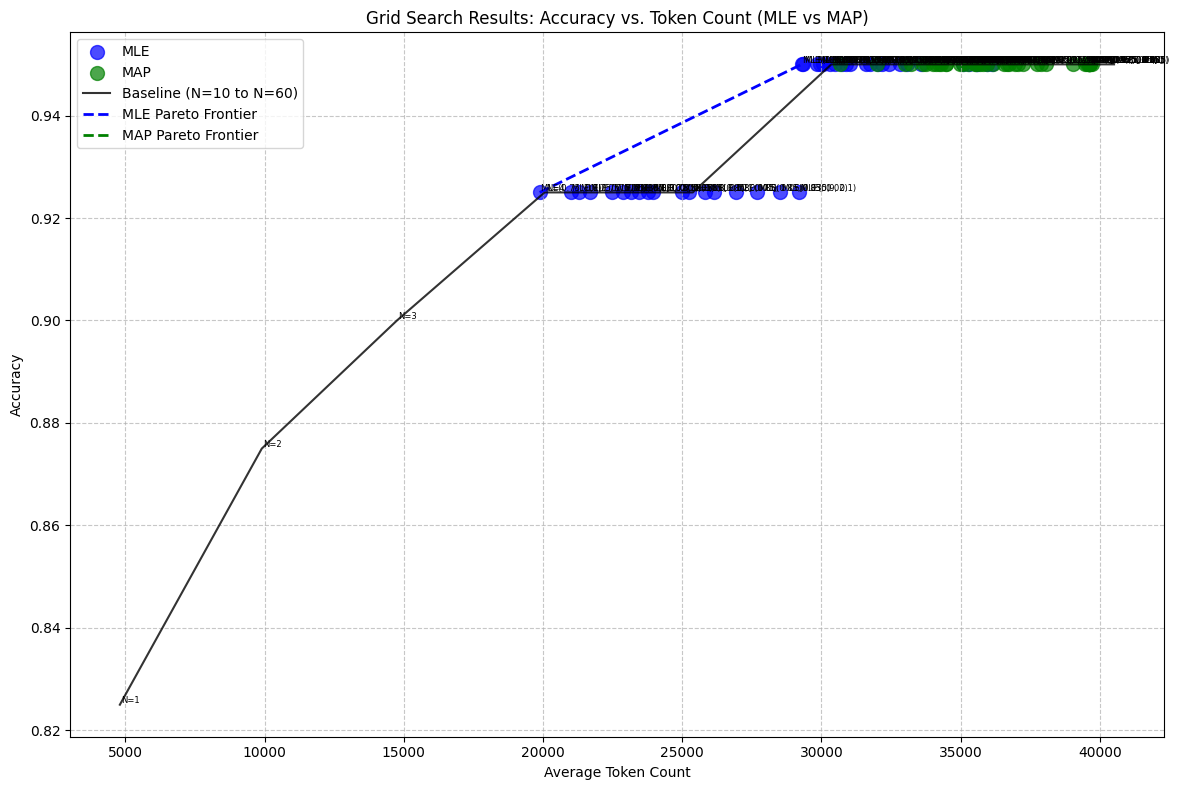


MLE Pareto-optimal configurations:
Target Score: 0.75, Percentile: 0.1, Accuracy: 0.9250, Avg Token Count: 19881.25
Target Score: 0.85, Percentile: 0.01, Accuracy: 0.9500, Avg Token Count: 29287.72

MAP Pareto-optimal configurations:
Target Score: 0.75, Percentile: 0.1, Accuracy: 0.9500, Avg Token Count: 30671.10


In [5]:
# Setting Panels
target_score_panel_values = [0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975]
percentile_panel_values = [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
max_N_panel = 8
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

In [6]:
peek_number = 5

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.5888      0.1438    0.9938    0.0059    0.9202    0.1128   11.1844    0.3358
1         0.4565      0.0747    0.9873    0.0070    0.9014    0.1133    0.9915    0.0055
2         0.4358      0.0651    0.9753    0.0090    0.9926    0.0292    0.9800    0.0112
3         0.4280      0.0684    0.9944    0.0246    0.7782    0.1855    1.0509    0.0347
4         0.5449      0.1461   43.9847    2.3801    0.7591    0.1838   61.4234    2.0890
5         0.4186      0.0189    0.9827    0.0025    0.9764    0.0082   71.0465    1.8965
6         0.6573      0.1089    0.7303    0.0748    0.7225    0.0772    0.7766    0.1199
7         0.6261      0.1181    0.6612    0.0943    0.6557    0.0965    0.9498    0.2272
8         0.2787      0.0185    1.3195    0.2678    0.5528    0.2444   26.8822    1.5123
9         0.5441      0.1487    0.9905    0.0025    0.8609    0.1505    0.9922    0.0087
10        0.5938      0.1681    0.9871    0.0048    0.9603    0.0728    1.3754    0.0850
11        0.6530     

Target Score Panel: [0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 16

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [5, 5, 5, 5, 5, 5, 10, 16, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 7, 8, 5, 5, 16, 5, 5, 5, 9, 5, 5, 5, 5]
MLE - Target Score: 0.75, Percentile: 0.01
MLE - Accuracy: 0.9250, Average Token Count: 40774.65
MLE Min N Required [5, 5, 5, 5, 5, 5, 8, 16, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 14, 5, 16, 5, 5, 5, 5, 5, 5, 6, 7, 5, 5, 16, 5, 5, 5, 8, 5, 5, 5, 5]
MLE - Target Score: 0.75, Percentile: 0.02
MLE - Accuracy: 0.9250, Average Token Count: 38941.35
MLE Min N Required [5, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 5, 5, 7, 5, 5, 5, 5]
MLE - Target Score: 0.75, Percentile: 0.035
MLE - Accuracy: 0.9250, Average Token Count: 37023.07
MLE Min N Required [5, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 5, 5, 5]


Target Score (MLE):  14%|█▍        | 1/7 [00:00<00:02,  2.73it/s]

MLE - Target Score: 0.75, Percentile: 0.05
MLE - Accuracy: 0.9250, Average Token Count: 36191.57
MLE Min N Required [5, 5, 5, 5, 5, 5, 6, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5]
MLE - Target Score: 0.75, Percentile: 0.075
MLE - Accuracy: 0.9250, Average Token Count: 34488.65
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5]
MLE - Target Score: 0.75, Percentile: 0.1
MLE - Accuracy: 0.9250, Average Token Count: 33256.10


MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 11, 11, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 7]
MLE - Target Score: 0.8, Percentile: 0.01
MLE - Accuracy: 0.9250, Average Token Count: 46671.45


MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 9, 9, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 6]
MLE - Target Score: 0.8, Percentile: 0.02
MLE - Accuracy: 0.9250, Average Token Count: 45227.90
MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 8, 8, 5, 5, 16, 5, 5, 5, 14, 5, 5, 5, 5]
MLE - Target Score: 0.8, Percentile: 0.035
MLE - Accuracy: 0.9250, Average Token Count: 43971.90


MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 7, 7, 5, 5, 16, 5, 5, 5, 13, 5, 5, 5, 5]
MLE - Target Score: 0.8, Percentile: 0.05
MLE - Accuracy: 0.9250, Average Token Count: 43149.53


Target Score (MLE):  29%|██▊       | 2/7 [00:00<00:01,  2.51it/s]

MLE Min N Required [5, 5, 5, 5, 5, 5, 14, 16, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 16, 5, 5, 5, 11, 5, 5, 5, 5]
MLE - Target Score: 0.8, Percentile: 0.075
MLE - Accuracy: 0.9250, Average Token Count: 41460.20
MLE Min N Required [5, 5, 5, 5, 5, 5, 12, 16, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 15, 5, 16, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 16, 5, 5, 5, 10, 5, 5, 5, 5]
MLE - Target Score: 0.8, Percentile: 0.1
MLE - Accuracy: 0.9250, Average Token Count: 40437.97


MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 7, 5, 5, 10]
MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9250, Average Token Count: 50400.40


MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 15, 5, 5, 16, 5, 5, 5, 16, 6, 5, 5, 9]
MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9250, Average Token Count: 49945.32
MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 14, 13, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 8]
MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9250, Average Token Count: 48665.45


MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 13, 11, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 7]
MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9250, Average Token Count: 47619.70


Target Score (MLE):  43%|████▎     | 3/7 [00:01<00:01,  2.31it/s]

MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 11, 10, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 6]
MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9250, Average Token Count: 46326.65
MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 10, 9, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5]
MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9250, Average Token Count: 45596.68


MLE Min N Required [5, 5, 5, 5, 7, 5, 16, 16, 7, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 11, 7, 5, 16]
MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 52956.65


MLE Min N Required [5, 5, 5, 5, 6, 5, 16, 16, 6, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 9, 6, 5, 16]
MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 52310.47
MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 8, 5, 5, 14]
MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9250, Average Token Count: 51477.20


MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 7, 5, 5, 12]
MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9250, Average Token Count: 50788.05


Target Score (MLE):  57%|█████▋    | 4/7 [00:01<00:01,  2.12it/s]

MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 6, 5, 5, 11]
MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9250, Average Token Count: 50465.32
MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 15, 5, 5, 16, 5, 5, 5, 16, 6, 5, 5, 10]
MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9250, Average Token Count: 50159.03


MLE Min N Required [5, 5, 5, 5, 9, 5, 16, 16, 10, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 7, 5, 5, 16, 15, 9, 5, 16]


MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 55547.53
MLE Min N Required [5, 5, 5, 5, 7, 5, 16, 16, 8, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 6, 5, 5, 16, 13, 8, 5, 16]
MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 54069.18
MLE Min N Required [5, 5, 5, 5, 6, 5, 16, 16, 7, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 11, 7, 5, 16]
MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 52864.50


MLE Min N Required [5, 5, 5, 5, 6, 5, 16, 16, 6, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 10, 6, 5, 16]
MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 52419.43
MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 6, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 9, 5, 5, 16]
MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9250, Average Token Count: 52061.75
MLE Min N Required [5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 8, 5, 5, 14]


Target Score (MLE):  71%|███████▏  | 5/7 [00:02<00:01,  1.97it/s]

MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9250, Average Token Count: 51477.20


MLE Min N Required [5, 5, 5, 5, 13, 5, 16, 16, 15, 5, 5, 8, 7, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 10, 5, 5, 16, 16, 13, 5, 16]
MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 59070.28
MLE Min N Required [5, 5, 5, 5, 11, 5, 16, 16, 12, 5, 5, 7, 6, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 8, 5, 5, 16, 16, 11, 5, 16]


MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 57224.82


MLE Min N Required [5, 5, 5, 5, 9, 5, 16, 16, 11, 5, 5, 6, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 7, 5, 5, 16, 16, 10, 5, 16]
MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 56114.00
MLE Min N Required [5, 5, 5, 5, 8, 5, 16, 16, 10, 5, 5, 6, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 6, 5, 5, 16, 15, 9, 5, 16]


MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 55089.53
MLE Min N Required [5, 5, 5, 5, 7, 5, 16, 16, 8, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 6, 5, 5, 16, 13, 8, 5, 16]
MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 54069.18
MLE Min N Required [5, 5, 5, 5, 7, 5, 16, 16, 8, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 12, 7, 5, 16]


Target Score (MLE):  86%|████████▌ | 6/7 [00:02<00:00,  1.83it/s]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 53551.03


MLE Min N Required [5, 5, 7, 5, 16, 5, 16, 16, 16, 5, 5, 16, 14, 16, 7, 16, 16, 9, 16, 5, 16, 5, 13, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 16, 16, 9, 16]
MLE - Target Score: 0.975, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 66370.18


MLE Min N Required [5, 5, 6, 5, 16, 5, 16, 16, 16, 5, 5, 16, 12, 16, 6, 16, 16, 8, 16, 5, 16, 5, 11, 5, 5, 5, 5, 16, 16, 5, 5, 16, 16, 5, 5, 16, 16, 16, 8, 16]
MLE - Target Score: 0.975, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 65869.20


MLE Min N Required [5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 16, 10, 16, 5, 16, 16, 7, 16, 5, 16, 5, 10, 5, 5, 5, 5, 16, 16, 5, 5, 16, 14, 5, 5, 16, 16, 16, 7, 16]
MLE - Target Score: 0.975, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 64932.78


MLE Min N Required [5, 5, 5, 5, 16, 5, 16, 16, 16, 5, 5, 16, 9, 16, 5, 16, 15, 6, 16, 5, 16, 5, 9, 5, 5, 5, 5, 16, 16, 5, 5, 16, 12, 5, 5, 16, 16, 16, 6, 16]
MLE - Target Score: 0.975, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 64261.93


MLE Min N Required [5, 5, 5, 5, 14, 5, 16, 16, 16, 5, 5, 14, 8, 16, 5, 16, 13, 6, 16, 5, 16, 5, 8, 5, 5, 5, 5, 16, 16, 5, 5, 16, 11, 5, 5, 16, 16, 15, 5, 16]
MLE - Target Score: 0.975, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 62760.25


Target Score (MLE): 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


MLE Min N Required [5, 5, 5, 5, 13, 5, 16, 16, 15, 5, 5, 12, 7, 16, 5, 16, 11, 5, 16, 5, 16, 5, 7, 5, 5, 5, 5, 16, 16, 5, 5, 16, 10, 5, 5, 16, 16, 13, 5, 16]
MLE - Target Score: 0.975, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 61210.80

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [5, 5, 5, 7, 8, 5, 11, 16, 16, 5, 5, 5, 5, 16, 5, 5, 16, 9, 16, 5, 16, 10, 5, 5, 6, 5, 5, 16, 16, 5, 5, 16, 5, 5, 7, 11, 7, 7, 5, 8]
MAP - Target Score: 0.75, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 52037.60


MAP Min N Required [5, 5, 5, 6, 7, 5, 9, 16, 16, 5, 5, 5, 5, 16, 5, 5, 16, 7, 15, 5, 16, 8, 5, 5, 5, 5, 5, 15, 15, 5, 5, 16, 5, 5, 6, 9, 6, 6, 5, 7]
MAP - Target Score: 0.75, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 49118.78
MAP Min N Required [5, 5, 5, 5, 6, 5, 8, 16, 16, 5, 5, 5, 5, 16, 5, 5, 16, 6, 13, 5, 16, 7, 5, 5, 5, 5, 5, 13, 13, 5, 5, 16, 5, 5, 6, 8, 5, 6, 5, 6]
MAP - Target Score: 0.75, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 47061.05
MAP Min N Required [5, 5, 5, 5, 5, 5, 7, 16, 15, 5, 5, 5, 5, 16, 5, 5, 15, 6, 12, 5, 16, 6, 5, 5, 5, 5, 5, 11, 12, 5, 5, 16, 5, 5, 5, 7, 5, 5, 5, 5]


MAP - Target Score: 0.75, Percentile: 0.05
MAP - Accuracy: 0.9250, Average Token Count: 44697.07
MAP Min N Required [5, 5, 5, 5, 5, 5, 6, 15, 13, 5, 5, 5, 5, 15, 5, 5, 13, 5, 10, 5, 16, 6, 5, 5, 5, 5, 5, 10, 10, 5, 5, 16, 5, 5, 5, 6, 5, 5, 5, 5]
MAP - Target Score: 0.75, Percentile: 0.075
MAP - Accuracy: 0.9250, Average Token Count: 42088.07


Target Score (MAP):  14%|█▍        | 1/7 [00:00<00:03,  1.78it/s]

MAP Min N Required [5, 5, 5, 5, 5, 5, 6, 13, 12, 5, 5, 5, 5, 14, 5, 5, 11, 5, 9, 5, 16, 5, 5, 5, 5, 5, 5, 9, 9, 5, 5, 15, 5, 5, 5, 6, 5, 5, 5, 5]
MAP - Target Score: 0.75, Percentile: 0.1
MAP - Accuracy: 0.9250, Average Token Count: 39964.18


MAP Min N Required [5, 5, 5, 10, 11, 5, 16, 16, 16, 6, 5, 5, 7, 16, 5, 5, 16, 12, 16, 6, 16, 13, 6, 5, 8, 5, 6, 16, 16, 5, 5, 16, 5, 5, 11, 16, 11, 11, 5, 13]
MAP - Target Score: 0.8, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 58219.05


MAP Min N Required [5, 5, 5, 9, 10, 5, 16, 16, 16, 5, 5, 5, 6, 16, 5, 5, 16, 10, 16, 5, 16, 12, 5, 5, 7, 5, 5, 16, 16, 5, 5, 16, 5, 5, 9, 16, 10, 10, 5, 11]
MAP - Target Score: 0.8, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 56660.03


MAP Min N Required [5, 5, 5, 7, 8, 5, 16, 16, 16, 5, 5, 5, 5, 16, 5, 5, 16, 9, 16, 5, 16, 10, 5, 5, 6, 5, 5, 16, 16, 5, 5, 16, 5, 5, 8, 16, 8, 8, 5, 9]
MAP - Target Score: 0.8, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 54658.12


MAP Min N Required [5, 5, 5, 7, 7, 5, 16, 16, 16, 5, 5, 5, 5, 16, 5, 5, 16, 8, 16, 5, 16, 9, 5, 5, 6, 5, 5, 16, 16, 5, 5, 16, 5, 5, 7, 16, 8, 7, 5, 8]
MAP - Target Score: 0.8, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 54095.97


MAP Min N Required [5, 5, 5, 6, 7, 5, 16, 16, 16, 5, 5, 5, 5, 16, 5, 5, 16, 7, 16, 5, 16, 8, 5, 5, 5, 5, 5, 16, 16, 5, 5, 16, 5, 5, 6, 14, 7, 7, 5, 7]
MAP - Target Score: 0.8, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 52953.47


Target Score (MAP):  29%|██▊       | 2/7 [00:01<00:03,  1.54it/s]

MAP Min N Required [5, 5, 5, 5, 6, 5, 14, 16, 16, 5, 5, 5, 5, 16, 5, 5, 16, 6, 16, 5, 16, 7, 5, 5, 5, 5, 5, 15, 15, 5, 5, 16, 5, 5, 6, 12, 6, 6, 5, 7]
MAP - Target Score: 0.8, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 51185.85


MAP Min N Required [5, 6, 5, 16, 16, 5, 16, 16, 16, 9, 5, 5, 11, 16, 5, 5, 16, 16, 16, 10, 16, 16, 9, 5, 12, 5, 9, 16, 16, 5, 5, 16, 8, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 64663.60


MAP Min N Required [5, 5, 5, 13, 15, 5, 16, 16, 16, 8, 5, 5, 9, 16, 5, 5, 16, 16, 16, 8, 16, 16, 8, 5, 11, 5, 8, 16, 16, 5, 5, 16, 6, 5, 14, 16, 16, 16, 5, 16]
MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 63251.10


MAP Min N Required [5, 5, 5, 11, 13, 5, 16, 16, 16, 7, 5, 5, 8, 16, 5, 5, 16, 14, 16, 7, 16, 15, 7, 5, 9, 5, 7, 16, 16, 5, 5, 16, 6, 5, 12, 16, 14, 14, 5, 16]
MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 61329.62


MAP Min N Required [5, 5, 5, 10, 12, 5, 16, 16, 16, 6, 5, 5, 7, 16, 5, 5, 16, 12, 16, 6, 16, 13, 6, 5, 8, 5, 6, 16, 16, 5, 5, 16, 5, 5, 11, 16, 13, 12, 5, 14]
MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 59162.05


MAP Min N Required [5, 5, 5, 9, 10, 5, 16, 16, 16, 5, 5, 5, 6, 16, 5, 5, 16, 11, 16, 6, 16, 12, 5, 5, 7, 5, 5, 16, 16, 5, 5, 16, 5, 5, 9, 16, 11, 11, 5, 13]
MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 57482.50


Target Score (MAP):  43%|████▎     | 3/7 [00:02<00:02,  1.38it/s]

MAP Min N Required [5, 5, 5, 8, 9, 5, 16, 16, 16, 5, 5, 5, 6, 16, 5, 5, 16, 10, 16, 5, 16, 10, 5, 5, 6, 5, 5, 16, 16, 5, 5, 16, 5, 5, 8, 16, 10, 9, 5, 11]
MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 56043.05


MAP Min N Required [9, 10, 5, 16, 16, 5, 16, 16, 16, 15, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 15, 5, 16, 5, 15, 16, 16, 5, 5, 16, 14, 5, 16, 16, 16, 16, 5, 16]


MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 68000.20
MAP Min N Required [7, 9, 5, 16, 16, 5, 16, 16, 16, 13, 5, 5, 16, 16, 5, 5, 16, 16, 16, 14, 16, 16, 13, 5, 16, 5, 13, 16, 16, 5, 5, 16, 12, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 67196.02


MAP Min N Required [6, 7, 5, 16, 16, 5, 16, 16, 16, 11, 5, 5, 14, 16, 5, 5, 16, 16, 16, 12, 16, 16, 11, 5, 15, 5, 11, 16, 16, 5, 5, 16, 10, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 66073.45
MAP Min N Required [6, 7, 5, 16, 16, 5, 16, 16, 16, 10, 5, 5, 13, 16, 5, 5, 16, 16, 16, 11, 16, 16, 10, 5, 13, 5, 10, 16, 16, 5, 5, 16, 9, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 65462.90


Target Score (MAP):  57%|█████▋    | 4/7 [00:03<00:02,  1.21it/s]

MAP Min N Required [5, 6, 5, 16, 16, 5, 16, 16, 16, 9, 5, 5, 11, 16, 5, 5, 16, 16, 16, 10, 16, 16, 9, 5, 12, 5, 9, 16, 16, 5, 5, 16, 8, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 64663.60
MAP Min N Required [5, 5, 5, 14, 16, 5, 16, 16, 16, 8, 5, 5, 10, 16, 5, 5, 16, 16, 16, 9, 16, 16, 8, 5, 10, 5, 8, 16, 16, 5, 5, 16, 7, 5, 14, 16, 16, 16, 5, 16]
MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 63735.43


MAP Min N Required [12, 15, 5, 16, 16, 5, 16, 16, 16, 16, 6, 8, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 6, 16, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 69341.45
MAP Min N Required [11, 12, 5, 16, 16, 5, 16, 16, 16, 16, 5, 7, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 68942.90


MAP Min N Required [9, 11, 5, 16, 16, 5, 16, 16, 16, 16, 5, 6, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 15, 16, 16, 5, 5, 16, 15, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 68412.98
MAP Min N Required [8, 10, 5, 16, 16, 5, 16, 16, 16, 15, 5, 6, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 15, 5, 16, 5, 14, 16, 16, 5, 5, 16, 13, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 67849.02


Target Score (MAP):  71%|███████▏  | 5/7 [00:04<00:01,  1.12it/s]

MAP Min N Required [7, 8, 5, 16, 16, 5, 16, 16, 16, 13, 5, 5, 16, 16, 5, 5, 16, 16, 16, 14, 16, 16, 13, 5, 16, 5, 12, 16, 16, 5, 5, 16, 12, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 67116.12
MAP Min N Required [6, 8, 5, 16, 16, 5, 16, 16, 16, 11, 5, 5, 15, 16, 5, 5, 16, 16, 16, 13, 16, 16, 11, 5, 15, 5, 11, 16, 16, 5, 5, 16, 10, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 66246.38


MAP Min N Required [16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 10, 16, 16, 16, 5, 9, 16, 16, 16, 16, 16, 16, 16, 8, 16, 10, 16, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 16, 8, 16]
MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 72208.82
MAP Min N Required [16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 9, 16, 16, 16, 5, 8, 16, 16, 16, 16, 16, 16, 16, 7, 16, 8, 16, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 16, 7, 16]


MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 71675.38
MAP Min N Required [15, 16, 5, 16, 16, 5, 16, 16, 16, 16, 8, 14, 16, 16, 5, 7, 16, 16, 16, 16, 16, 16, 16, 6, 16, 7, 16, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 16, 6, 16]


MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 71030.35
MAP Min N Required [14, 16, 5, 16, 16, 5, 16, 16, 16, 16, 7, 12, 16, 16, 5, 6, 16, 16, 16, 16, 16, 16, 16, 5, 16, 6, 16, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 16, 6, 16]
MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 70341.77


Target Score (MAP):  86%|████████▌ | 6/7 [00:05<00:00,  1.01it/s]

MAP Min N Required [12, 14, 5, 16, 16, 5, 16, 16, 16, 16, 6, 11, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 6, 16, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 69630.77
MAP Min N Required [11, 12, 5, 16, 16, 5, 16, 16, 16, 16, 5, 10, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 5, 16, 16, 5, 16, 16, 16, 16, 5, 16]
MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 69303.10


MAP Min N Required [16, 16, 6, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 7, 16, 16, 14, 16, 16, 16, 16, 16, 16]
MAP - Target Score: 0.975, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 76949.30


MAP Min N Required [16, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 6, 16, 16, 12, 16, 16, 16, 16, 16, 16]
MAP - Target Score: 0.975, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 76397.65


MAP Min N Required [16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 5, 16, 16, 11, 16, 16, 16, 16, 16, 16]
MAP - Target Score: 0.975, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 76133.98


MAP Min N Required [16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 5, 5, 16, 16, 9, 16, 16, 16, 16, 16, 16]
MAP - Target Score: 0.975, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 75756.65


MAP Min N Required [16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 14, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 5, 5, 16, 16, 8, 16, 16, 16, 16, 14, 16]
MAP - Target Score: 0.975, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 75141.45


Target Score (MAP): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

MAP Min N Required [16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 12, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 11, 16, 16, 16, 5, 5, 16, 16, 7, 16, 16, 16, 16, 12, 16]
MAP - Target Score: 0.975, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 74462.25


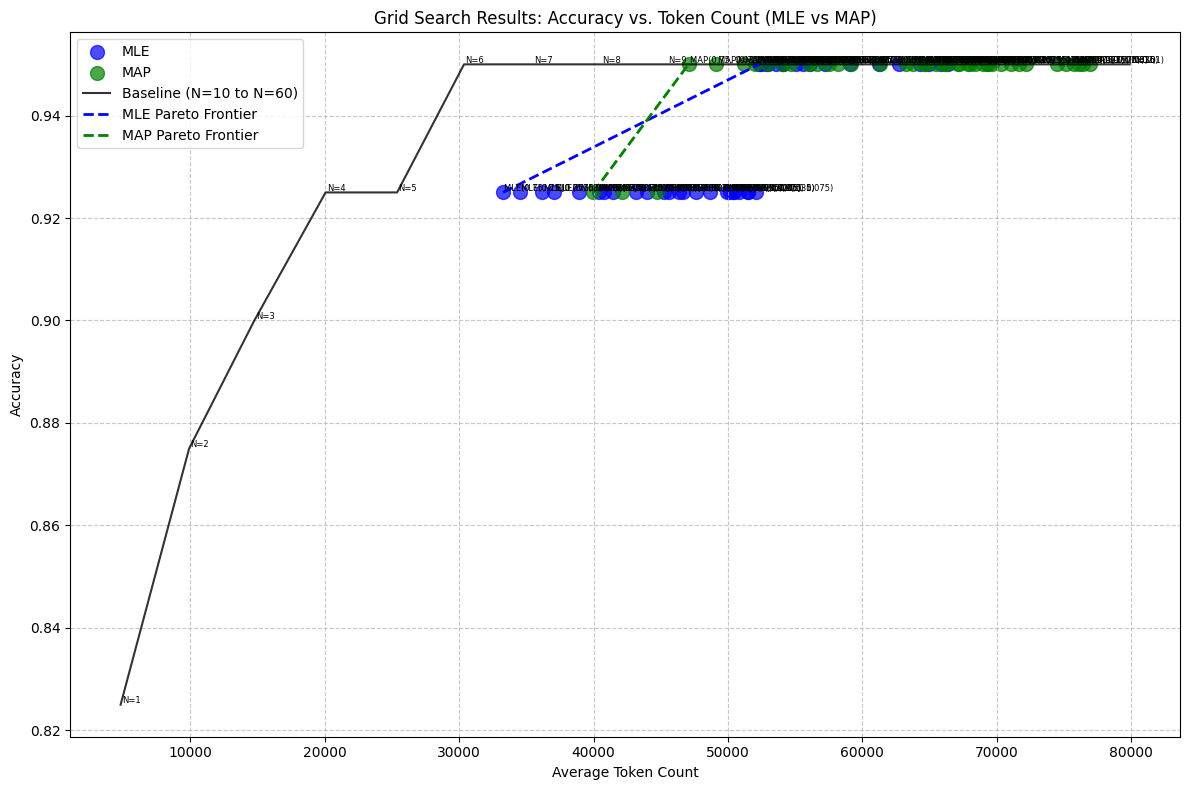


MLE Pareto-optimal configurations:
Target Score: 0.75, Percentile: 0.1, Accuracy: 0.9250, Avg Token Count: 33256.10
Target Score: 0.9, Percentile: 0.02, Accuracy: 0.9500, Avg Token Count: 52310.47

MAP Pareto-optimal configurations:
Target Score: 0.75, Percentile: 0.1, Accuracy: 0.9250, Avg Token Count: 39964.18
Target Score: 0.75, Percentile: 0.035, Accuracy: 0.9500, Avg Token Count: 47061.05


In [7]:
max_N_panel = 16
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

In [8]:
peek_number = 10

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.5888      0.1438   10.3920    0.3287    0.8758    0.1187   11.1844    0.3358
1         0.4565      0.0747    0.9921    0.0072    0.8539    0.1900    0.9915    0.0055
2         0.4358      0.0651    0.9785    0.0085    0.8421    0.1180    0.9800    0.0112
3         0.4280      0.0684    0.9904    0.0169    1.0491    0.0911    1.0509    0.0347
4         0.5449      0.1461   78.2462    2.8693    0.8698    0.1560   61.4234    2.0890
5         0.4186      0.0189   64.3756    1.7755    0.9475    0.1010   71.0465    1.8965
6         0.6573      0.1089    0.7335    0.0885    0.7278    0.0894    0.7766    0.1199
7         0.6261      0.1181    0.8087    0.1794    0.7494    0.1553    0.9498    0.2272
8         0.2787      0.0185    1.7059    0.3705    0.7543    0.1624   26.8822    1.5123
9         0.5441      0.1487    0.9887    0.0038    0.7992    0.2043    0.9922    0.0087
10        0.5938      0.1681    0.9862    0.0045    0.9068    0.0715    1.3754    0.0850
11        0.6530     

Target Score Panel: [0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 32

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MLE - Target Score: 0.75, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 70191.45
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MLE - Target Score: 0.75, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 69591.85


MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MLE - Target Score: 0.75, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 68701.45
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MLE - Target Score: 0.75, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 67867.20


MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MLE - Target Score: 0.75, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 66680.00
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]


Target Score (MLE):  14%|█▍        | 1/7 [00:00<00:02,  2.18it/s]

MLE - Target Score: 0.75, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 66086.40


MLE Min N Required [10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 10, 24, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 32, 10, 10, 10, 11, 10, 10, 10, 10]
MLE - Target Score: 0.8, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 77887.40


MLE Min N Required [10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MLE - Target Score: 0.8, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 75146.73
MLE Min N Required [10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MLE - Target Score: 0.8, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 73383.02


MLE Min N Required [10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MLE - Target Score: 0.8, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 72420.15
MLE Min N Required [10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MLE - Target Score: 0.8, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 71265.25


Target Score (MLE):  29%|██▊       | 2/7 [00:00<00:02,  2.06it/s]

MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MLE - Target Score: 0.8, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 70191.45


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 13, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 19, 10, 10, 10, 10]


MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 87481.55


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 11, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 16, 10, 10, 10, 10]
MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 86584.77


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 14, 10, 10, 10, 10]
MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 86067.12


MLE Min N Required [10, 10, 10, 10, 10, 10, 31, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 30, 10, 10, 10, 32, 10, 10, 10, 13, 10, 10, 10, 10]
MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 85321.80
MLE Min N Required [10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 26, 10, 10, 10, 32, 10, 10, 10, 11, 10, 10, 10, 10]
MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 82860.90
MLE Min N Required [10, 10, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]


Target Score (MLE):  43%|████▎     | 3/7 [00:01<00:02,  1.80it/s]

MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 80549.57


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 22, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 15, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 13]
MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 93296.00


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 19, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 13, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 11]
MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 92034.93


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 17, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 11, 10, 10, 32, 10, 10, 10, 28, 10, 10, 10, 10]
MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 90550.85


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 15, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 25, 10, 10, 10, 10]
MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 89509.65


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 13, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 22, 10, 10, 10, 10]
MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 88194.62


Target Score (MLE):  57%|█████▋    | 4/7 [00:02<00:01,  1.60it/s]

MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 11, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 19, 10, 10, 10, 10]
MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 87079.48


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 21, 10, 10, 32, 11, 10, 10, 32, 10, 10, 10, 19]
MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 97728.43


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 28, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 18, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 16]
MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 95504.35


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 24, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 15, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 14]
MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 93930.93


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 21, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 14, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 13]
MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 93032.82


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 18, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 12, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 11]
MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 91726.62


Target Score (MLE):  71%|███████▏  | 5/7 [00:03<00:01,  1.44it/s]

MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 16, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 11, 10, 10, 32, 10, 10, 10, 30, 10, 10, 10, 10]
MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 90686.75


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 32, 15, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 17, 10, 10, 32, 11, 10, 10, 31]
MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 103927.40


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 32, 13, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 28, 10, 10, 32, 15, 10, 10, 32, 10, 10, 10, 27]
MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 101552.25


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 32, 11, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 24, 10, 10, 32, 13, 10, 10, 32, 10, 10, 10, 23]
MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 99480.93


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 22, 10, 10, 32, 11, 10, 10, 32, 10, 10, 10, 21]
MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 98322.90


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 30, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 19, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 18]
MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 96486.60


Target Score (MLE):  86%|████████▌ | 6/7 [00:04<00:00,  1.29it/s]

MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 27, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 17, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 16]
MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 95105.75


MLE Min N Required [10, 10, 10, 10, 20, 10, 32, 32, 30, 10, 10, 16, 13, 32, 10, 14, 23, 15, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 32, 10, 10, 32, 21, 17, 10, 32]
MLE - Target Score: 0.975, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 116412.75


MLE Min N Required [10, 10, 10, 10, 17, 10, 32, 32, 25, 10, 10, 14, 12, 32, 10, 12, 20, 13, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 30, 10, 10, 32, 18, 15, 10, 32]
MLE - Target Score: 0.975, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 113011.20


MLE Min N Required [10, 10, 10, 10, 15, 10, 32, 32, 22, 10, 10, 12, 10, 32, 10, 10, 17, 11, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 26, 10, 10, 32, 16, 13, 10, 32]
MLE - Target Score: 0.975, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 110004.48
MLE Min N Required [10, 10, 10, 10, 13, 10, 32, 32, 20, 10, 10, 11, 10, 32, 10, 10, 15, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 23, 10, 10, 32, 14, 11, 10, 32]


MLE - Target Score: 0.975, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 107527.18
MLE Min N Required [10, 10, 10, 10, 12, 10, 32, 32, 17, 10, 10, 10, 10, 32, 10, 10, 13, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 20, 10, 10, 32, 12, 10, 10, 32]
MLE - Target Score: 0.975, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 105646.40


Target Score (MLE): 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


MLE Min N Required [10, 10, 10, 10, 10, 10, 32, 32, 15, 10, 10, 10, 10, 32, 10, 10, 12, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 32, 18, 10, 10, 32, 11, 10, 10, 32]
MLE - Target Score: 0.975, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 104467.00

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MAP - Target Score: 0.75, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 73142.32


MAP Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MAP - Target Score: 0.75, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 72123.88
MAP Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 28, 10, 32, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]


MAP - Target Score: 0.75, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 69780.98
MAP Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 25, 10, 32, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MAP - Target Score: 0.75, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 68350.88


Percentile:  67%|██████▋   | 4/6 [00:00<00:00, 10.48it/s]

MAP Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 22, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MAP - Target Score: 0.75, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 66810.20


Target Score (MAP):  14%|█▍        | 1/7 [00:00<00:03,  1.82it/s]

MAP Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MAP - Target Score: 0.75, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 65792.23


MAP Min N Required [10, 10, 10, 10, 10, 10, 20, 12, 11, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 12, 10, 32, 13, 10, 10, 32, 10, 10, 10, 14, 10, 12, 10, 10]
MAP - Target Score: 0.8, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 84547.57


MAP Min N Required [10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 28, 11, 10, 10, 32, 10, 10, 10, 12, 10, 10, 10, 10]
MAP - Target Score: 0.8, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 81117.43


MAP Min N Required [10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 24, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MAP - Target Score: 0.8, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 78826.90


MAP Min N Required [10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MAP - Target Score: 0.8, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 77108.07


MAP Min N Required [10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MAP - Target Score: 0.8, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 75175.15


Target Score (MAP):  29%|██▊       | 2/7 [00:01<00:03,  1.56it/s]

MAP Min N Required [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10]
MAP - Target Score: 0.8, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 73678.05


MAP Min N Required [10, 11, 10, 10, 10, 10, 32, 19, 18, 14, 10, 10, 10, 32, 14, 10, 10, 10, 32, 10, 32, 10, 10, 10, 12, 18, 10, 32, 21, 10, 10, 32, 10, 10, 10, 25, 11, 19, 10, 12]


MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 96662.73
MAP Min N Required [10, 10, 10, 10, 10, 10, 32, 17, 16, 12, 10, 10, 10, 32, 12, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 15, 10, 32, 18, 10, 10, 32, 10, 10, 10, 22, 10, 16, 10, 10]


MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 92993.05


MAP Min N Required [10, 10, 10, 10, 10, 10, 32, 14, 14, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 13, 10, 32, 15, 10, 10, 32, 10, 10, 10, 19, 10, 14, 10, 10]
MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 90142.23


MAP Min N Required [10, 10, 10, 10, 10, 10, 32, 13, 12, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 12, 10, 32, 14, 10, 10, 32, 10, 10, 10, 17, 10, 13, 10, 10]
MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 88813.85


MAP Min N Required [10, 10, 10, 10, 10, 10, 30, 11, 11, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 12, 10, 10, 32, 10, 10, 10, 15, 10, 11, 10, 10]
MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 86522.73


Target Score (MAP):  43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

MAP Min N Required [10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 32, 11, 10, 10, 32, 10, 10, 10, 13, 10, 10, 10, 10]
MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 84784.38


MAP Min N Required [13, 18, 17, 10, 15, 10, 32, 32, 32, 24, 10, 10, 14, 32, 24, 12, 10, 11, 32, 10, 32, 10, 10, 10, 20, 29, 10, 32, 32, 10, 12, 32, 15, 10, 18, 32, 20, 32, 10, 23]
MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 116316.75


MAP Min N Required [11, 15, 15, 10, 13, 10, 32, 31, 29, 21, 10, 10, 12, 32, 20, 10, 10, 10, 32, 10, 32, 10, 10, 10, 17, 25, 10, 32, 32, 10, 10, 32, 12, 10, 16, 32, 17, 29, 10, 20]
MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 111380.23


MAP Min N Required [10, 13, 13, 10, 11, 10, 32, 27, 25, 18, 10, 10, 10, 32, 17, 10, 10, 10, 32, 10, 32, 10, 10, 10, 15, 21, 10, 32, 29, 10, 10, 32, 11, 10, 13, 32, 15, 25, 10, 17]
MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 105908.32
MAP Min N Required [10, 12, 11, 10, 10, 10, 32, 24, 22, 16, 10, 10, 10, 32, 16, 10, 10, 10, 32, 10, 32, 10, 10, 10, 13, 19, 10, 32, 26, 10, 10, 32, 10, 10, 12, 32, 13, 23, 10, 15]


MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 102496.00
MAP Min N Required [10, 10, 10, 10, 10, 10, 32, 21, 19, 14, 10, 10, 10, 32, 14, 10, 10, 10, 32, 10, 32, 10, 10, 10, 12, 17, 10, 32, 22, 10, 10, 32, 10, 10, 10, 30, 12, 20, 10, 13]
MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 98853.98


Target Score (MAP):  57%|█████▋    | 4/7 [00:03<00:02,  1.03it/s]

MAP Min N Required [10, 10, 10, 10, 10, 10, 32, 19, 17, 12, 10, 10, 10, 32, 12, 10, 10, 10, 32, 10, 32, 10, 10, 10, 10, 15, 10, 32, 20, 10, 10, 32, 10, 10, 10, 27, 10, 18, 10, 12]
MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 95590.40


MAP Min N Required [19, 25, 26, 10, 21, 10, 32, 32, 32, 32, 12, 13, 21, 32, 32, 18, 10, 19, 32, 10, 32, 10, 10, 10, 28, 32, 11, 32, 32, 10, 16, 32, 22, 10, 28, 32, 29, 32, 10, 32]
MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 128129.07


MAP Min N Required [16, 21, 22, 10, 18, 10, 32, 32, 32, 29, 10, 11, 18, 32, 29, 15, 10, 16, 32, 10, 32, 10, 10, 10, 24, 32, 10, 32, 32, 10, 14, 32, 18, 10, 24, 32, 25, 32, 10, 30]
MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 122910.48


MAP Min N Required [14, 18, 19, 10, 16, 10, 32, 32, 32, 25, 10, 10, 15, 32, 25, 13, 10, 14, 32, 10, 32, 10, 10, 10, 21, 30, 10, 32, 32, 10, 12, 32, 16, 10, 20, 32, 22, 32, 10, 26]
MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 118426.05


MAP Min N Required [12, 17, 17, 10, 14, 10, 32, 32, 32, 23, 10, 10, 14, 32, 22, 12, 10, 12, 32, 10, 32, 10, 10, 10, 19, 27, 10, 32, 32, 10, 11, 32, 14, 10, 18, 32, 19, 32, 10, 23]
MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 115048.93


MAP Min N Required [11, 14, 15, 10, 12, 10, 32, 32, 29, 20, 10, 10, 12, 32, 19, 10, 10, 11, 32, 10, 32, 10, 10, 10, 16, 23, 10, 32, 32, 10, 10, 32, 12, 10, 16, 32, 17, 29, 10, 20]
MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 111052.52


Target Score (MAP):  71%|███████▏  | 5/7 [00:05<00:02,  1.19s/it]

MAP Min N Required [10, 13, 13, 10, 11, 10, 32, 28, 26, 18, 10, 10, 11, 32, 17, 10, 10, 10, 32, 10, 32, 10, 10, 10, 14, 21, 10, 32, 30, 10, 10, 32, 11, 10, 14, 32, 15, 26, 10, 18]
MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 106846.18


MAP Min N Required [31, 32, 32, 10, 32, 15, 32, 32, 32, 32, 22, 25, 32, 32, 32, 32, 10, 32, 32, 10, 32, 10, 19, 14, 32, 32, 20, 32, 32, 10, 26, 32, 32, 10, 32, 32, 32, 32, 10, 32]
MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 142119.17


MAP Min N Required [27, 32, 32, 10, 29, 13, 32, 32, 32, 32, 19, 21, 31, 32, 32, 28, 10, 31, 32, 10, 32, 10, 16, 12, 32, 32, 17, 32, 32, 10, 23, 32, 31, 10, 32, 32, 32, 32, 10, 32]
MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 139243.45


MAP Min N Required [23, 29, 32, 10, 25, 11, 32, 32, 32, 32, 16, 18, 26, 32, 32, 24, 10, 26, 32, 10, 32, 10, 14, 10, 32, 32, 14, 32, 32, 10, 19, 32, 27, 10, 32, 32, 32, 32, 10, 32]
MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 134458.02


MAP Min N Required [21, 26, 29, 10, 23, 10, 32, 32, 32, 32, 14, 16, 24, 32, 32, 21, 10, 24, 32, 10, 32, 10, 13, 10, 29, 32, 13, 32, 32, 10, 17, 32, 24, 10, 31, 32, 32, 32, 10, 32]
MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 131415.92


MAP Min N Required [18, 23, 26, 10, 20, 10, 32, 32, 32, 31, 13, 14, 20, 32, 31, 19, 10, 20, 32, 10, 32, 10, 11, 10, 26, 32, 11, 32, 32, 10, 15, 32, 21, 10, 27, 32, 27, 32, 10, 32]
MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 127091.52


Target Score (MAP):  86%|████████▌ | 6/7 [00:07<00:01,  1.49s/it]

MAP Min N Required [16, 20, 23, 10, 17, 10, 32, 32, 32, 28, 11, 13, 18, 32, 28, 17, 10, 18, 32, 10, 32, 10, 10, 10, 23, 32, 10, 32, 32, 10, 13, 32, 18, 10, 24, 32, 24, 32, 10, 31]
MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 123266.05


MAP Min N Required [32, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 19, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 32, 10, 32, 32, 32, 32, 23, 32]
MAP - Target Score: 0.975, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 151533.98


MAP Min N Required [32, 32, 32, 12, 32, 29, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 17, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 10, 32, 32, 32, 32, 20, 32]
MAP - Target Score: 0.975, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 150429.17


MAP Min N Required [32, 32, 32, 10, 32, 25, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 14, 32, 28, 32, 32, 32, 32, 32, 18, 32, 32, 32, 10, 32, 32, 32, 32, 17, 32]
MAP - Target Score: 0.975, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 148809.10


MAP Min N Required [32, 32, 32, 10, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 13, 32, 25, 32, 32, 32, 32, 32, 16, 32, 32, 32, 10, 32, 32, 32, 32, 15, 32]
MAP - Target Score: 0.975, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 147786.02


MAP Min N Required [32, 32, 32, 10, 32, 19, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 11, 31, 21, 32, 32, 28, 32, 32, 14, 32, 32, 32, 10, 32, 32, 32, 32, 13, 32]
MAP - Target Score: 0.975, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 146346.00


Target Score (MAP): 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]

MAP Min N Required [32, 32, 32, 10, 32, 17, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 10, 32, 32, 10, 32, 10, 27, 19, 32, 32, 25, 32, 32, 13, 29, 32, 32, 10, 32, 32, 32, 32, 12, 32]
MAP - Target Score: 0.975, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 145067.33


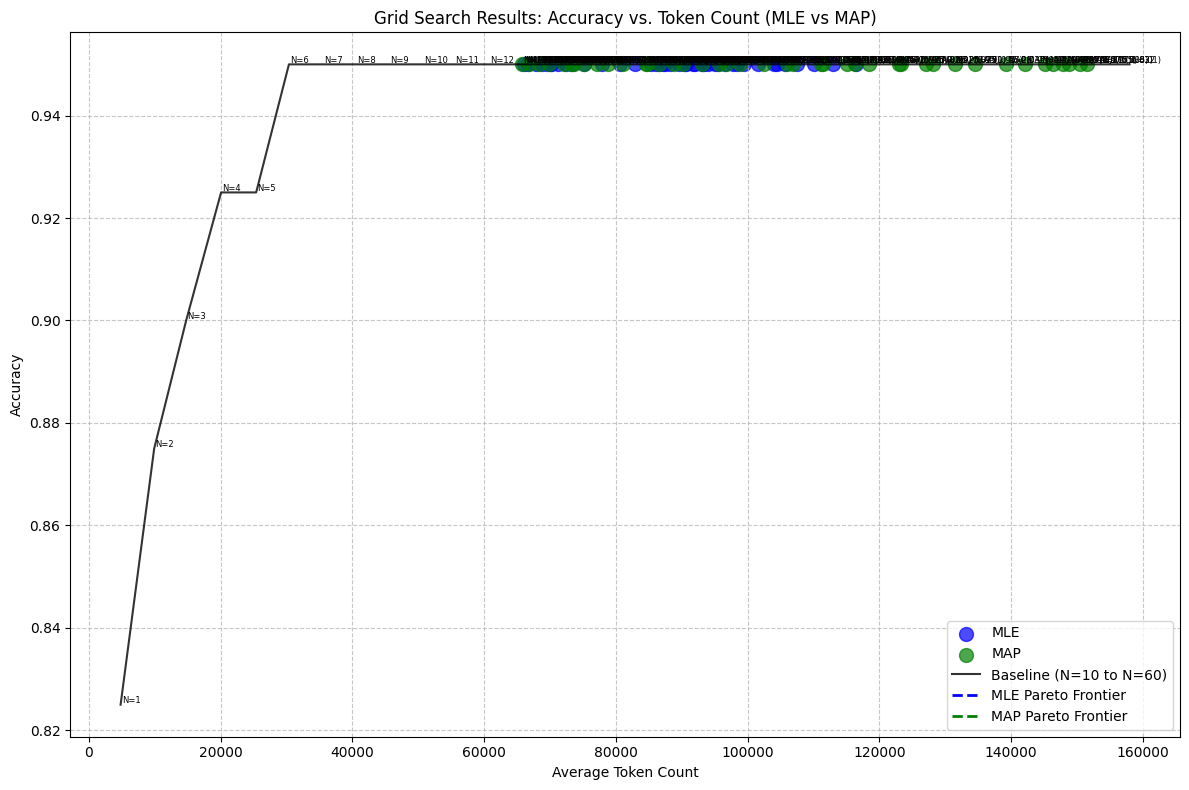


MLE Pareto-optimal configurations:
Target Score: 0.75, Percentile: 0.1, Accuracy: 0.9500, Avg Token Count: 66086.40

MAP Pareto-optimal configurations:
Target Score: 0.75, Percentile: 0.1, Accuracy: 0.9500, Avg Token Count: 65792.23


In [9]:
max_N_panel = 32
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

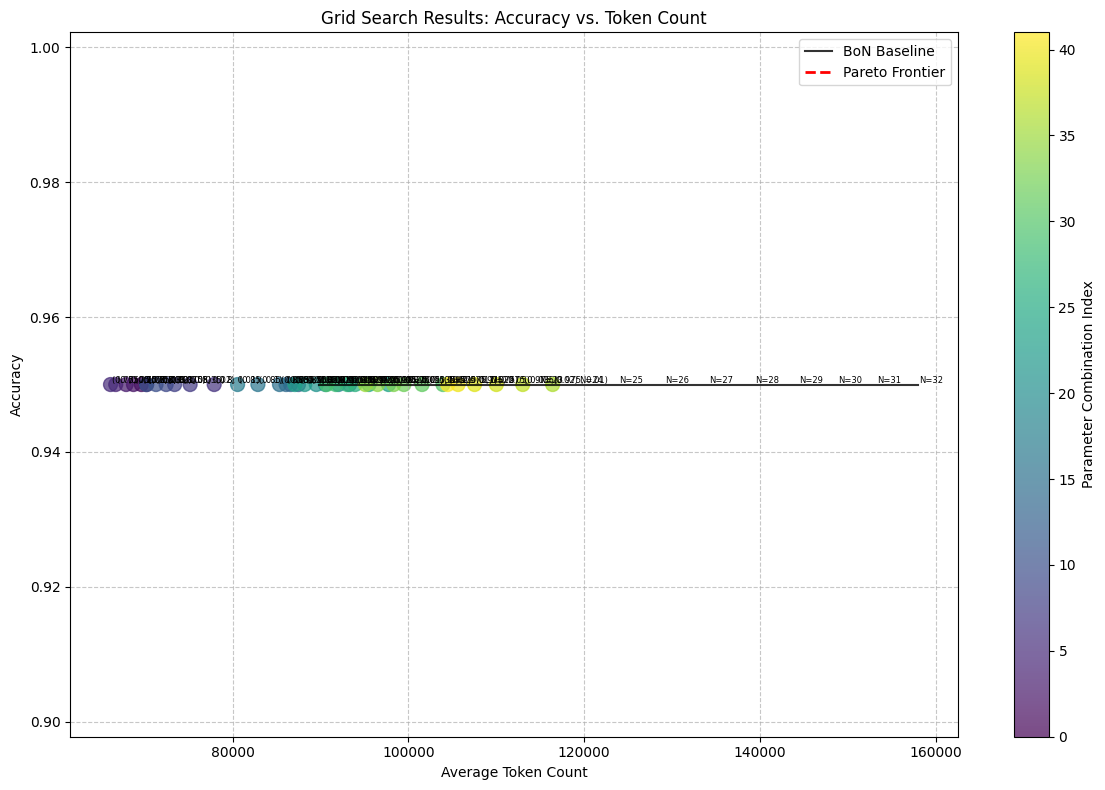

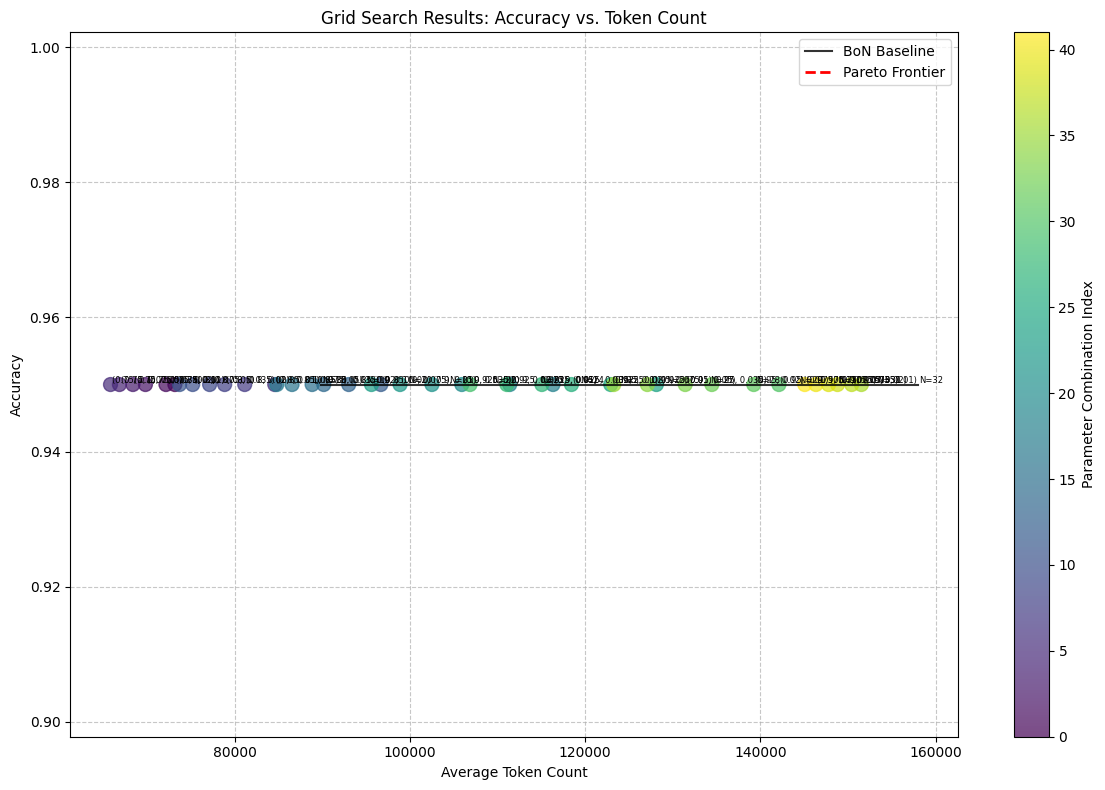

In [10]:
plot_optscale_start(mle_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel, 17)
plot_optscale_start(map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel, 17)

In [11]:
peek_number = 20

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.5888      0.1438    1.2838    0.0647    0.8871    0.1161   11.1844    0.3358
1         0.4565      0.0747    0.9931    0.0057    0.9378    0.0527    0.9915    0.0055
2         0.4358      0.0651    0.9787    0.0089    0.9212    0.0408    0.9800    0.0112
3         0.4280      0.0684    0.9873    0.0116    0.9228    0.0458    1.0509    0.0347
4         0.5449      0.1461    4.1316    0.5392    0.9637    0.1382   61.4234    2.0890
5         0.4186      0.0189   66.2380    1.9429    0.8957    0.0948   71.0465    1.8965
6         0.6573      0.1089    0.7280    0.0876    0.7254    0.0880    0.7766    0.1199
7         0.6261      0.1181    0.9628    0.2379    0.7963    0.2681    0.9498    0.2272
8         0.2787      0.0185    2.6808    0.4535    0.7543    0.1387   26.8822    1.5123
9         0.5441      0.1487    0.9906    0.0079    0.8020    0.4660    0.9922    0.0087
10        0.5938      0.1681   21.2380    0.6969    1.0202    0.0427    1.3754    0.0850
11        0.6530     

Target Score Panel: [0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 64

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.75, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 124594.68


MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.75, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 124594.68


MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.75, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 124594.68


MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 61, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.75, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 123761.90


Target Score (MLE):  14%|█▍        | 1/7 [00:00<00:04,  1.42it/s]

MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 53, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.75, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 121387.50
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 47, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.75, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 119776.73


MLE Min N Required [20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.8, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 130592.05
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.8, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 128037.48


MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.8, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 126899.48
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.8, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 126005.55


Target Score (MLE):  29%|██▊       | 2/7 [00:01<00:03,  1.45it/s]

MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.8, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 125190.62
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.8, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 124594.68


MLE Min N Required [20, 20, 20, 20, 20, 20, 55, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 49, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.85, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 152332.27
MLE Min N Required [20, 20, 20, 20, 20, 20, 47, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 42, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.85, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 148943.17


MLE Min N Required [20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.85, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 145887.55
MLE Min N Required [20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.85, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 144092.25


Target Score (MLE):  43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]

MLE Min N Required [20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 60, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.85, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 141049.17
MLE Min N Required [20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 54, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.85, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 137766.80


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 22, 20, 20, 20, 20]
MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 158731.23
MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]


MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 158266.62
MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 158266.62


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 158266.62
MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]


Target Score (MLE):  57%|█████▋    | 4/7 [00:03<00:02,  1.07it/s]

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 158266.62
MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 158266.62


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 33, 20, 20, 20, 26]
MLE - Target Score: 0.925, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 163812.25
MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 28, 20, 20, 20, 23]


MLE - Target Score: 0.925, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 161500.55
MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 24, 20, 20, 20, 20]
MLE - Target Score: 0.925, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 159469.00


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 22, 20, 20, 20, 20]
MLE - Target Score: 0.925, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 158731.23
MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.925, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 158266.62


Target Score (MLE):  71%|███████▏  | 5/7 [00:04<00:01,  1.01it/s]

MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MLE - Target Score: 0.925, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 158266.62


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 29, 20, 20, 20, 20, 20, 48, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 24, 20, 20, 64, 20, 20, 20, 56, 20, 20, 20, 44]
MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 178150.73


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 25, 20, 20, 20, 20, 20, 41, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 48, 20, 20, 20, 37]
MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 172276.50


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 21, 20, 20, 20, 20, 20, 35, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 41, 20, 20, 20, 32]
MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 167953.55
MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 37, 20, 20, 20, 29]


MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 165884.20
MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 32, 20, 20, 20, 25]
MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 163122.25


Target Score (MLE):  86%|████████▌ | 6/7 [00:05<00:01,  1.08s/it]

MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 28, 20, 20, 20, 22]
MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 161043.75


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 60, 22, 20, 20, 25, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 50, 20, 20, 64, 29, 20, 20, 64, 20, 31, 20, 64]
MLE - Target Score: 0.975, Percentile: 0.01
MLE - Accuracy: 0.9500, Average Token Count: 201820.33


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 51, 20, 20, 20, 22, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 43, 20, 20, 64, 25, 20, 20, 64, 20, 26, 20, 64]
MLE - Target Score: 0.975, Percentile: 0.02
MLE - Accuracy: 0.9500, Average Token Count: 196822.55


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 44, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 37, 20, 20, 64, 21, 20, 20, 64, 20, 23, 20, 64]
MLE - Target Score: 0.975, Percentile: 0.035
MLE - Accuracy: 0.9500, Average Token Count: 192805.55


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 39, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 33, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 63]
MLE - Target Score: 0.975, Percentile: 0.05
MLE - Accuracy: 0.9500, Average Token Count: 190307.35


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 34, 20, 20, 20, 20, 20, 59, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 28, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 55]
MLE - Target Score: 0.975, Percentile: 0.075
MLE - Accuracy: 0.9500, Average Token Count: 185575.27


Target Score (MLE): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


MLE Min N Required [20, 20, 20, 20, 20, 20, 64, 30, 20, 20, 20, 20, 20, 53, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 25, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 49]
MLE - Target Score: 0.975, Percentile: 0.1
MLE - Accuracy: 0.9500, Average Token Count: 182191.73

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.75, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 124594.68


MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.75, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 124594.68


MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.75, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 124594.68


MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 59, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.75, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 123168.30
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 51, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.75, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 120866.35
MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 45, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


Target Score (MAP):  14%|█▍        | 1/7 [00:00<00:04,  1.47it/s]

MAP - Target Score: 0.75, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 119281.98


MAP Min N Required [20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.8, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 133268.83


MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.8, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 129927.40


MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.8, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 127495.43


MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.8, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 126601.50


MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.8, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 125488.60


Target Score (MAP):  29%|██▊       | 2/7 [00:01<00:03,  1.29it/s]

MAP Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.8, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 124892.65


MAP Min N Required [20, 20, 20, 20, 20, 20, 58, 20, 20, 21, 20, 20, 20, 21, 20, 20, 29, 20, 64, 20, 64, 20, 20, 20, 20, 20, 22, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.85, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 157755.73


MAP Min N Required [20, 20, 20, 20, 20, 20, 49, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 56, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.85, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 153025.73
MAP Min N Required [20, 20, 20, 20, 20, 20, 42, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 48, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]


MAP - Target Score: 0.85, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 149079.40
MAP Min N Required [20, 20, 20, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 43, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.85, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 147149.52


Target Score (MAP):  43%|████▎     | 3/7 [00:02<00:03,  1.04it/s]

MAP Min N Required [20, 20, 20, 20, 20, 20, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 37, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.85, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 144429.55
MAP Min N Required [20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 33, 20, 20, 20, 58, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.85, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 140790.90


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 27, 39, 33, 20, 20, 20, 42, 32, 20, 47, 20, 64, 20, 64, 20, 20, 20, 31, 20, 33, 64, 20, 20, 29, 64, 20, 20, 20, 28, 20, 24, 29, 26]
MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 177009.05


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 23, 33, 28, 20, 20, 20, 36, 27, 20, 40, 20, 64, 20, 64, 20, 20, 20, 26, 20, 28, 64, 20, 20, 25, 64, 20, 20, 20, 24, 20, 20, 24, 22]
MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 169230.30


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 29, 24, 20, 20, 20, 31, 23, 20, 35, 20, 64, 20, 64, 20, 20, 20, 22, 20, 24, 64, 20, 20, 21, 64, 20, 20, 20, 21, 20, 20, 21, 20]
MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 164117.55


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 26, 22, 20, 20, 20, 28, 21, 20, 31, 20, 64, 20, 64, 20, 20, 20, 20, 20, 22, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 161568.45


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 22, 20, 20, 20, 20, 24, 20, 20, 27, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 159730.77


Target Score (MAP):  57%|█████▋    | 4/7 [00:04<00:03,  1.22s/it]

MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 21, 20, 20, 24, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20]
MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 158642.20


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 37, 61, 46, 20, 20, 20, 64, 43, 20, 64, 25, 64, 20, 64, 20, 20, 20, 41, 20, 45, 64, 30, 20, 40, 64, 20, 20, 23, 44, 20, 36, 39, 39]
MAP - Target Score: 0.925, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 202664.60


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 32, 52, 39, 20, 20, 20, 56, 37, 20, 56, 21, 64, 20, 64, 20, 20, 20, 35, 20, 38, 64, 25, 20, 34, 64, 20, 20, 20, 37, 20, 31, 33, 33]
MAP - Target Score: 0.925, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 190587.40


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 27, 44, 33, 20, 20, 20, 48, 32, 20, 48, 20, 64, 20, 64, 20, 20, 20, 30, 20, 33, 64, 22, 20, 29, 64, 20, 20, 20, 32, 20, 26, 29, 28]
MAP - Target Score: 0.925, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 180487.77


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 24, 40, 30, 20, 20, 20, 43, 28, 20, 43, 20, 64, 20, 64, 20, 20, 20, 27, 20, 29, 64, 20, 20, 26, 64, 20, 20, 20, 29, 20, 24, 26, 25]
MAP - Target Score: 0.925, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 174994.48


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 21, 34, 26, 20, 20, 20, 37, 24, 20, 37, 20, 64, 20, 64, 20, 20, 20, 24, 20, 25, 64, 20, 20, 23, 64, 20, 20, 20, 25, 20, 21, 22, 22]
MAP - Target Score: 0.925, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 168136.40


Target Score (MAP):  71%|███████▏  | 5/7 [00:06<00:03,  1.50s/it]

MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 20, 31, 23, 20, 20, 20, 33, 22, 20, 33, 20, 64, 20, 64, 20, 20, 20, 21, 20, 23, 64, 20, 20, 20, 64, 20, 20, 20, 22, 20, 20, 20, 20]
MAP - Target Score: 0.925, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 164318.08


MAP Min N Required [28, 20, 20, 20, 20, 25, 64, 58, 64, 64, 20, 20, 21, 64, 64, 20, 64, 42, 64, 20, 64, 20, 20, 20, 63, 20, 64, 64, 50, 20, 61, 64, 24, 20, 40, 64, 29, 62, 60, 64]
MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 237654.92


MAP Min N Required [24, 20, 20, 20, 20, 21, 64, 49, 64, 59, 20, 20, 20, 64, 56, 20, 64, 36, 64, 20, 64, 20, 20, 20, 54, 20, 58, 64, 43, 20, 52, 64, 21, 20, 34, 64, 24, 53, 51, 57]
MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 225622.35


MAP Min N Required [21, 20, 20, 20, 20, 20, 64, 42, 64, 51, 20, 20, 20, 64, 48, 20, 64, 31, 64, 20, 64, 20, 20, 20, 46, 20, 50, 64, 37, 20, 44, 64, 20, 20, 29, 56, 21, 45, 43, 49]
MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 214166.73


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 38, 64, 46, 20, 20, 20, 64, 43, 20, 64, 28, 64, 20, 64, 20, 20, 20, 41, 20, 44, 64, 33, 20, 40, 64, 20, 20, 26, 50, 20, 41, 39, 44]
MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 207472.00


MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 33, 60, 40, 20, 20, 20, 64, 37, 20, 59, 24, 64, 20, 64, 20, 20, 20, 36, 20, 39, 64, 28, 20, 34, 64, 20, 20, 22, 43, 20, 35, 34, 38]
MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 197636.90


Target Score (MAP):  86%|████████▌ | 6/7 [00:09<00:01,  1.95s/it]

MAP Min N Required [20, 20, 20, 20, 20, 20, 64, 29, 54, 35, 20, 20, 20, 58, 33, 20, 52, 21, 64, 20, 64, 20, 20, 20, 32, 20, 34, 64, 25, 20, 31, 64, 20, 20, 20, 39, 20, 31, 30, 34]
MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 189567.45


MAP Min N Required [63, 32, 64, 53, 37, 59, 64, 64, 64, 64, 20, 35, 49, 64, 64, 51, 64, 64, 64, 20, 64, 20, 26, 20, 64, 20, 64, 64, 64, 20, 64, 64, 54, 20, 64, 64, 64, 64, 64, 64]
MAP - Target Score: 0.975, Percentile: 0.01
MAP - Accuracy: 0.9500, Average Token Count: 276925.60


MAP Min N Required [54, 27, 56, 45, 32, 50, 64, 64, 64, 64, 20, 30, 42, 64, 64, 43, 64, 64, 64, 20, 64, 20, 22, 20, 64, 20, 64, 64, 64, 20, 64, 64, 46, 20, 64, 64, 54, 64, 64, 64]
MAP - Target Score: 0.975, Percentile: 0.02
MAP - Accuracy: 0.9500, Average Token Count: 267674.95


MAP Min N Required [46, 23, 48, 39, 27, 43, 64, 64, 64, 64, 20, 26, 36, 64, 64, 37, 64, 64, 64, 20, 64, 20, 20, 20, 64, 20, 64, 64, 64, 20, 64, 64, 39, 20, 64, 64, 46, 64, 64, 64]
MAP - Target Score: 0.975, Percentile: 0.035
MAP - Accuracy: 0.9500, Average Token Count: 260749.50


MAP Min N Required [41, 21, 43, 35, 24, 39, 64, 64, 64, 64, 20, 23, 32, 64, 64, 33, 64, 63, 64, 20, 64, 20, 20, 20, 64, 20, 64, 64, 64, 20, 64, 64, 35, 20, 60, 64, 42, 64, 64, 64]
MAP - Target Score: 0.975, Percentile: 0.05
MAP - Accuracy: 0.9500, Average Token Count: 256110.52


MAP Min N Required [36, 20, 37, 30, 21, 33, 64, 64, 64, 64, 20, 20, 28, 64, 64, 29, 64, 55, 64, 20, 64, 20, 20, 20, 64, 20, 64, 64, 64, 20, 64, 64, 31, 20, 52, 64, 36, 64, 64, 64]
MAP - Target Score: 0.975, Percentile: 0.075
MAP - Accuracy: 0.9500, Average Token Count: 250050.60


Target Score (MAP): 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]

MAP Min N Required [32, 20, 33, 27, 20, 30, 64, 61, 64, 64, 20, 20, 25, 64, 64, 26, 64, 49, 64, 20, 64, 20, 20, 20, 64, 20, 64, 64, 57, 20, 62, 64, 27, 20, 46, 64, 32, 64, 61, 64]
MAP - Target Score: 0.975, Percentile: 0.1
MAP - Accuracy: 0.9500, Average Token Count: 244275.83


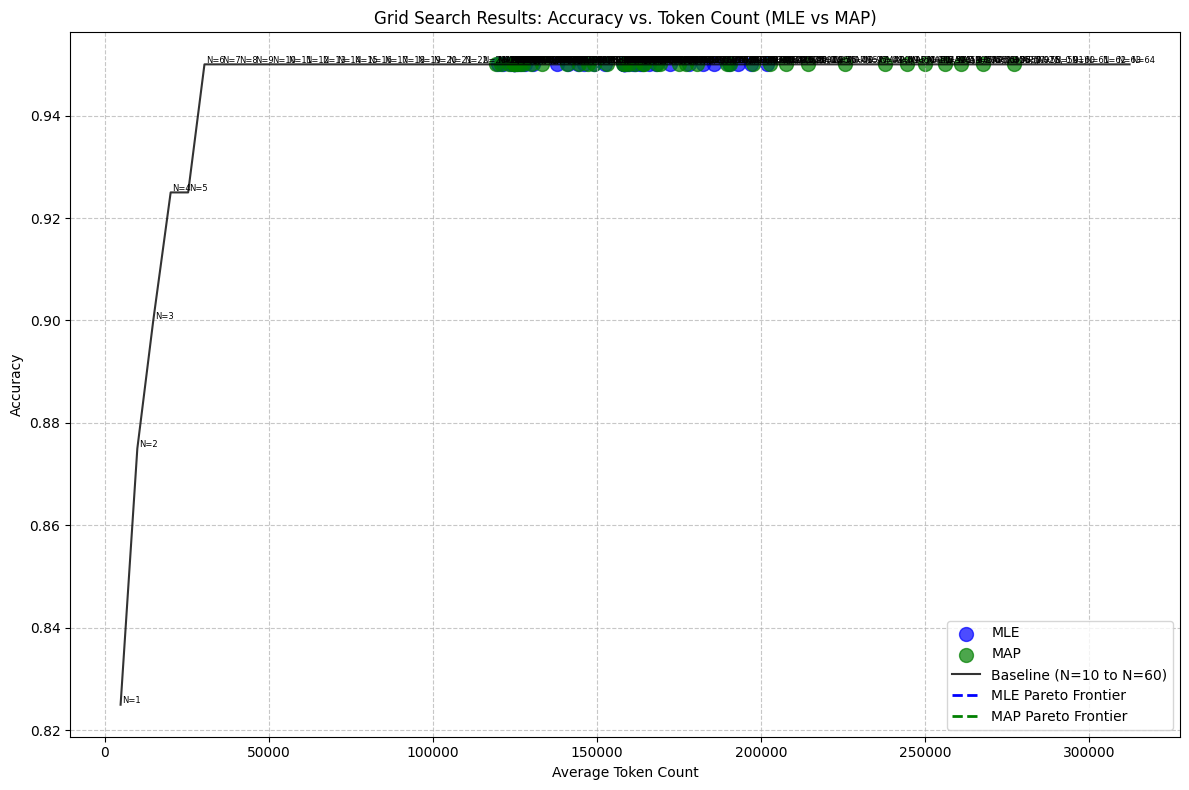


MLE Pareto-optimal configurations:
Target Score: 0.75, Percentile: 0.1, Accuracy: 0.9500, Avg Token Count: 119776.73

MAP Pareto-optimal configurations:
Target Score: 0.75, Percentile: 0.1, Accuracy: 0.9500, Avg Token Count: 119281.98


In [12]:
max_N_panel = 64
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)